## Welcome Kaggler!

With this diving course I invite you to learn some machine learning basics. This course is designed as a series of kernels that guides you through different topics and hopefully you can discover some hidden treasures that push you forward on your data science road. You don't have to pick the courses in sequence if you are only interested in some topics that are covered. If you are new I would recommend you to take them step by step one after another. ;-)

Just fork the kernels and have fun! :-)

UPDATE - I'm currently working on the series to change from interactive mode to guided. Don't wonder and have caution - Work in progress ;-)

* [Prepare to start](https://www.kaggle.com/allunia/titanic-dive-through-prepare-to-start): Within this kernel we will prepare our data such that we can use it to proceed. Don't except nice feature selection or extraction techniques here because we will stay as simple as possible. Without a clear motivation we won't change any features. Consequently we are only going to explore how to deal with missing values and how to turn objects to numerical values. In the end we will store our prepared data as output such that we can continue working with it in the next kernel.
* [MyClassifier](https://www.kaggle.com/allunia/titanic-dive-through-myclassifier): Are you ready to code your own classifier? Within this kernel you will build logistic regression from scratch. By implementing the model ourselves we can understand the assumptions behind it. This knowledge will help us to make better decisions in the next kernel where we will use this model and build some diagnosis tools to improve its performance.
* [The feature cave](https://www.kaggle.com/allunia/titanic-dive-through-feature-cave): By using our own logistic regression model we will explore how we can improve by adding a bias term and why we should encode categorical features. 
* **Feature scaling and outliers**: Why is it important to scale features and to detect outliers? By analyzing the model structure we will discover how our gradients and our model performance are influenced by these topics. 

## Get your equipment

We have entered the wrack as we are going to understand the heart of our learning process - how gradients flow.  ;-)

### Packages and data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import os
print(os.listdir("../input"))

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

['titanicdivethrough-featurecave', 'titanic']


In [2]:
train = pd.read_csv("../input/titanicdivethrough-featurecave/feature_cave_train.csv", index_col=0)
test = pd.read_csv("../input/titanicdivethrough-featurecave/feature_cave_test.csv", index_col=0)

# To compare our results in the end, we need the original data
original_train = train.copy()

### Self-made logistic regression
Again we have to use our beginners diving equipment - our selfmade logistic regression classifier. This way we make sure that we have access to every part of our model and that we can try some experiments to find out how our model reacts. If you have done the other courses you may wonder if this is the improved version - yes! It includes the bias term:

In [3]:
class MyClassifier:
    
    def __init__(self, n_features):
        self.n_features = n_features
        np.random.seed(0)
        self.w = np.random.normal(loc=0, scale=0.01, size=n_features + 1)
        self.losses = []
    
    def predict(self, x):
        y = sigmoid(np.sum(self.w[:-1]*x, axis=1) + self.w[-1])
        return y
    
    def loss(self, y, t):
        E = - np.sum(t * np.log(y) + (1-t) * np.log(1-y))
        return E
        
    def gradient(self, x, y, t):
        grad = np.zeros(self.w.shape[0])
        for d in range(self.w.shape[0]):
            if d != self.n_features:
                grad[d] = np.sum((y-t)*x[:, d])
            else:
                grad[d] = np.sum((y-t))
        return grad
        
    def update(self, eta, grad):
        w_next = np.zeros(self.w.shape) 
        for d in range(self.w.shape[0]):
            w_next[d] = self.w[d] - eta * grad[d]
        return w_next

    def learn(self, x, t, eta=0.000001, max_steps=100000, tol=0.00001):
        y = self.predict(x)
        for step in range(max_steps):
            error = self.loss(y, t)
            grad = self.gradient(x, y, t)
            self.w = self.update(eta, grad)
            self.losses.append(error)
            y = self.predict(x)
            error_next = self.loss(y, t)
            if (error - error_next) < tol:
                break
                
    def decide(self, y):
        decision = np.zeros(y.shape)
        decision[y >= 0.5] = 1
        decision[y < 0.5] = 0
        return decision.astype(np.int)
    
    def accuracy(self, y, t):
        N = y.shape[0]
        return 1/N * np.sum(1 - np.abs(t-y))
        
    def score(self, x, t):
        y = self.predict(x)
        y = self.decide(y)
        return self.accuracy(y, t)

In [4]:
def sigmoid(x):
    result = 1/(1+np.exp(-x))
    return result

### Split into train and validation data

To see how well our model performs, we will split our train data into train and validation data. This way we can try to become better by looking at the performance on the validation data. 

In [5]:
from sklearn.model_selection import train_test_split

features = train.drop(["PassengerId", "Survived"], axis=1).columns

X = train[features].values
Y = train.Survived.values

x_train, x_val, t_train, t_val = train_test_split(X, Y, random_state=0)

train_df = pd.DataFrame(x_train, columns=features)
train_df["Survived"] = t_train
val_df = pd.DataFrame(x_val, columns=features)
val_df["Survived"] = t_val

train_df.head()

,Sex,Age,Fare,Parch_0,Parch_1,Parch_2,Parch_5,Parch_3,Parch_4,Parch_6,Parch_9,SibSp_1,SibSp_0,SibSp_3,SibSp_4,SibSp_2,SibSp_5,SibSp_8,Pclass_3,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2,Survived
0,0.0,28.0,7.8958,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
1,1.0,17.0,7.9250,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
2,0.0,30.0,16.1000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
3,0.0,22.0,7.2500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
4,1.0,45.0,13.5000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1


Let's start!

## Station 1: Recap gradient magnitudes

In the last kernels we have already seen that the gradients of the loss $E$ with respect to the parameters $w$ depend on the features $x$:

$$ \frac{\partial E}{\partial w_{d}} = \sum_{n=1}^{N} (y_{n} - t_{n}) \cdot x_{n, d}$$

By taking just one step and looking at the gradients we have revealed that the different feature value ranges result in different gradient magnitudes. Currently our gradients are mainly driven by high contributions of features with high value ranges whereas the others only exhibit low impact on the weight and loss change. This is not our desire as we want to have those features to have a high impact on the gradients that are mainly resposible for the survival of our passengers. ;-)

Let's have a look at the gradients per feature by taking one iteration step with your logistic regression model. Which features show the highest gradients?

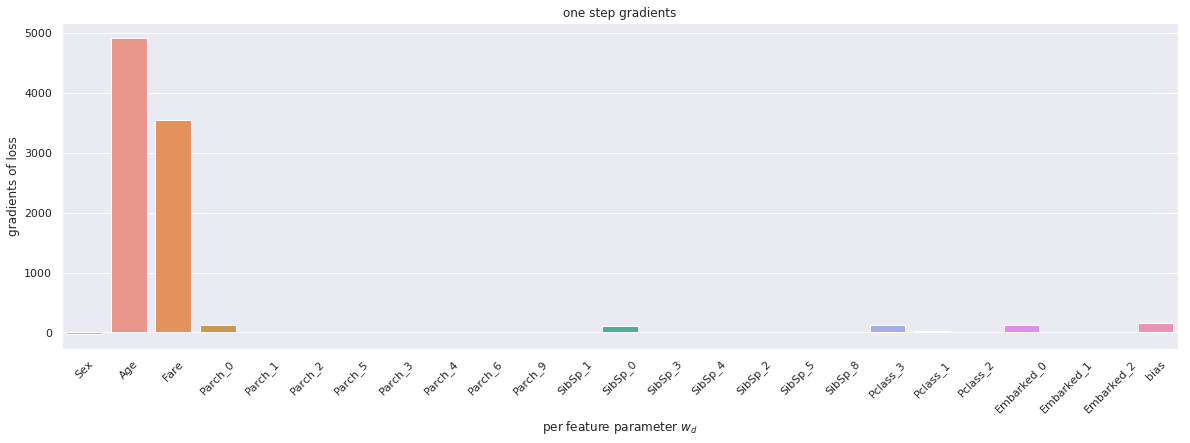

In [6]:
one_step_classifier = MyClassifier(n_features = len(features))
predictions = one_step_classifier.predict(x_train)
grad = one_step_classifier.gradient(x_train, predictions, t_train)

features_names = list(features) + ["bias"]

plt.figure(figsize=(20,6))
sns.barplot(x=features_names, y=grad)
plt.ylabel("gradients of loss")
plt.xlabel("per feature parameter $w_{d}$")
plt.title("one step gradients")
plt.xticks(rotation=45);

You should see that the fare and the age exhibit the highest gradients. Why is it bad that we make large steps in weight update for high valued gradients and only small steps for low valued gradients? What does this mean for our speed and performance of gradient descent especially if you use a limit of loss change (tolerance) as a stopping criterion? 

## Station 2 - Scaling the age

To obtain faster convergence we shall scale the age and the fare feature to value ranges close to those of our remaining features. In our case they are categorical and hold values either of zero or one. One way to get close to this range is standard scaling: For each value we subtract the feature mean $\mu$ and divide by standard deviation $\sigma$: 

$$x_{scaled} = \frac{x - \mu_{x, train}}{\sigma_{x, train}} $$

This way our new distribution has zero mean and unit variance. Consequently the majority of our values is close to those of our remaining features. As you usually do not know new data like the test data, you should compute the mean and the standard deviation on the train data. Now it's your turn: Scale the age feature! You can do so by implementing your own scaling method or by using [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) of scikit-learn:

In [7]:
from sklearn.preprocessing import StandardScaler
# scale the train and test ages

scaler = StandardScaler()
train.Age = scaler.fit_transform(train.Age.values.reshape(-1,1))
test.Age = scaler.transform(test.Age.values.reshape(-1,1))

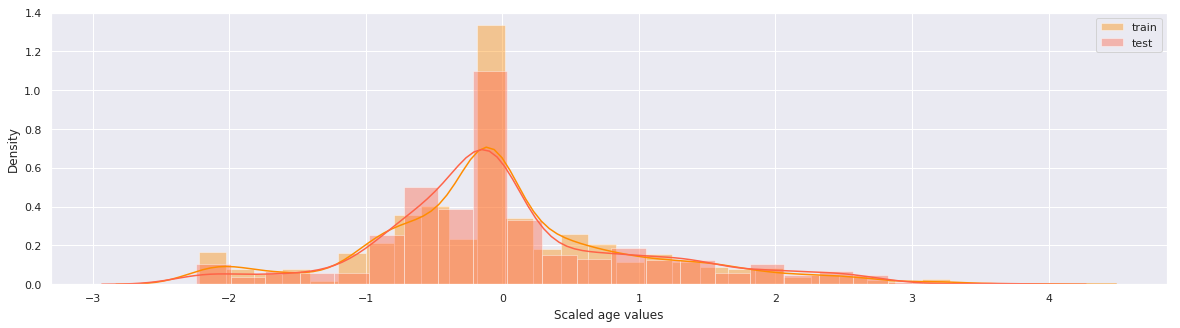

In [8]:
# visualize the scaled ages distributions of train and test
# hint: you can use sns.distplot of the opensource tool seaborn
plt.figure(figsize=(20,5))
sns.distplot(train.Age.values, label="train", color="darkorange")
sns.distplot(test.Age.values, label="test", color="tomato");
plt.xlabel("Scaled age values");
plt.ylabel("Density")
plt.legend();

In [9]:
assert(np.round(train.Age.mean(),1) == 0)
assert(np.round(train.Age.median(), 1) == -0.1)
assert(np.round(train.Age.min(), 1) == -2.2)
assert(np.round(train.Age.max(), 1) == 3.9)
assert(np.round(test.Age.mean(),1) == 0)
assert(np.round(test.Age.median(), 1) == -0.1)
assert(np.round(test.Age.min(), 1) == -2.2)
assert(np.round(test.Age.max(), 1) == 3.6)

## Station 3 - Exotic impact

Ok, we are done with the ages, but what about the fares? Let's have a look at them:

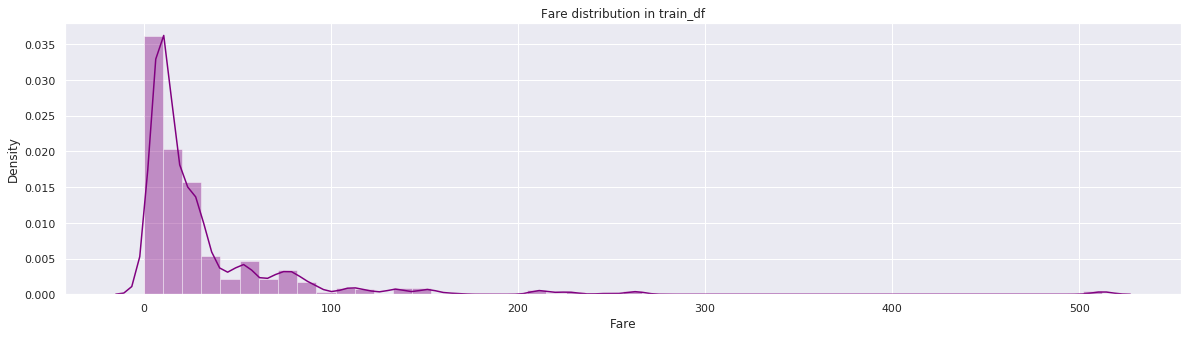

In [10]:
plt.figure(figsize=(20,5))
sns.distplot(train_df.Fare.values, color="Purple")
plt.xlabel("Fare")
plt.ylabel("Density")
plt.title("Fare distribution in train_df");

Can you explain why this fare distribution causes a new problem not only with convergence speed but with bad predictions as well? If you are not sure why, look at the equation to compute the gradient for the parameter update for $w_{fare}$:

$$ \frac{\partial E}{\partial w_{fare}} = \sum_{n=1}^{N} (y_{n} - t_{n}) \cdot x_{n, fare}$$

$$ w_{fare}^{\tau+1} = w_{fare}^{\tau} - \eta \cdot \frac{\partial E}{\partial w_{fare}}$$

We are summing over all $n$ passengers and our initial predictions $y$ are relatively close to 0.5. Thus the term $(y_{n}-t_{n})$ is always close to 0.5 for $t_{n}=0$ or close to $-0.5$ for $t_{n} = 1$. There is nothing wrong with that. BUT, you are multiplying with $x_{n,fare}$! If it's an outlier this yields a high contribution to the gradient in the sum. Even if all other contributions might be of a low value, one high outlier value already shifts the entire gradient towards higher values as well. This is a bad learning behaviour! If our model gradients are mainly driven by outliers, it tries to learn the survival of these exotic values, ignoring the majority of all remaining passengers. :-( Uff! 

Ok, before we are going to fix this, let's play safe and have a look at the distribution of all contributions $(y_{n} - t_{n}) \cdot x_{n, fare}$ of our one step learning classifier:

In [11]:
def get_grad_contributions(y, t, x_d):
    contributions = (y - t) * x_d
    return contributions

fare_contributions = get_grad_contributions(predictions, t_train, train_df.Fare.values)

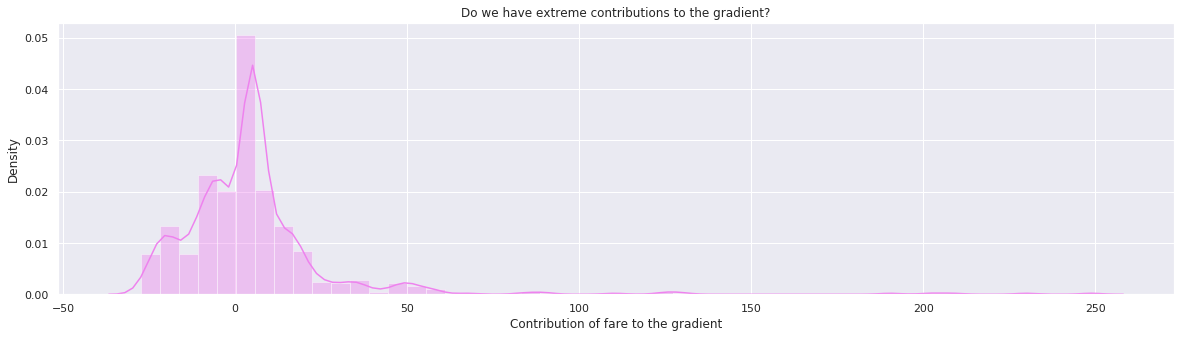

In [12]:
plt.figure(figsize=(20,5))
sns.distplot(fare_contributions, color="violet")
plt.xlabel("Contribution of fare to the gradient");
plt.ylabel("Density")
plt.title("Do we have extreme contributions to the gradient?");

Can you see the few high valued contributions above 50 that are mainly responsible for our high fare gradient?

## Station 4 - Transforming and scaling the fare

** Many models like normally distributed features!**

And logistic regression does! But why?

Ok, imagine you have a powerful feature that is normally distributed and the decision boundary for belonging to group 0 or 1 is exactly the mean $\mu = 0$. For example all samples with negative values survived the disaster and the positive ones died. In this case we would obtain the following gradient contributions for survived passengers:

For $x = \mu: (0.5 - 1) \cdot 0 = 0 $

For $x < \mu:  (0.5 - 1) \cdot sign(-) > 0$

For $x > \mu: (0.5 - 1) \cdot sign(+) < 0$

As we assumed a normal distribution we would obtain zero for the total gradient as the sum/integral over all passengers. Consequently we would not update our initial parameter $w_{initial}$. We are already done! :-) But what if our "perfect" and powerful feature distribution exhibits an outlier? In this case we would yield a gradient $\partial _{w} E > 0$ and our model tries to update the parameter $w$ such that it fits the outlier at the expense of other passenger samples. This problem is similar for skewed feature distributions: High absolute values contribute more to the sum than many small ones. It the same problem as with the mean. One example:

In [13]:
# create some normally distributed samples:
original = np.random.normal(loc=0, scale=1, size=200)
# add an outlier
shifted = np.array(original.tolist() + [1000])
# comute the mean
print(np.mean(original))
print(np.mean(shifted))

0.009194310123484485
4.984272945396502


Due to the very high outlier, the mean is shifted towards higher values even though the majority is centered around zero. The same problem applies to the gradient contributions: One very high outlier contribution shifts the gradient towards learning exotics ignoring the remaining samples. For skewed distributions this is true as well: The contributions of the longer tail have more impact on the gradient than the others and makes our model learning from exotics as well. 

### It's your turn
Perform a log-transformation to scale the fares such that they look somehow normally distributed:

$$ x_{transformed, fare} = \log (x_{fare} + 1) $$

Of course you can use (and should try out) different constants than 1 to get away with the signularity of the log function at zero. But for matching solutions I would recommend to use this one. ;-)

In [14]:
# Just a method to plot our fare distribution with some statistics
def show_fare_distribution():
    plt.figure(figsize=(20,5))
    sns.kdeplot(train[train.Survived==0].Fare, color="Blue", shade=True)
    sns.kdeplot(train[train.Survived==1].Fare, color="Green", shade=True)
    plt.axvline(np.max(train.Fare.values), color="Yellow")
    plt.axvline(np.min(train.Fare.values), color="Yellow")
    plt.axvline(np.mean(train.Fare.values)+np.std(train.Fare.values), color="Orange")
    plt.axvline(np.mean(train.Fare.values)-np.std(train.Fare.values), color="Orange")
    plt.axvline(np.mean(train.Fare.values), color="Red")
    plt.axvline(np.median(train.Fare.values), color="Black")
    plt.xlabel("Fare")
    plt.ylabel("Density")
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

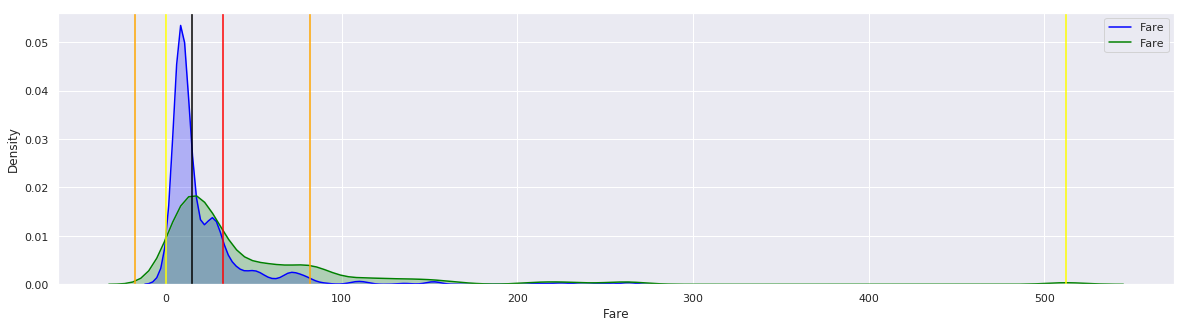

In [15]:
show_fare_distribution()

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

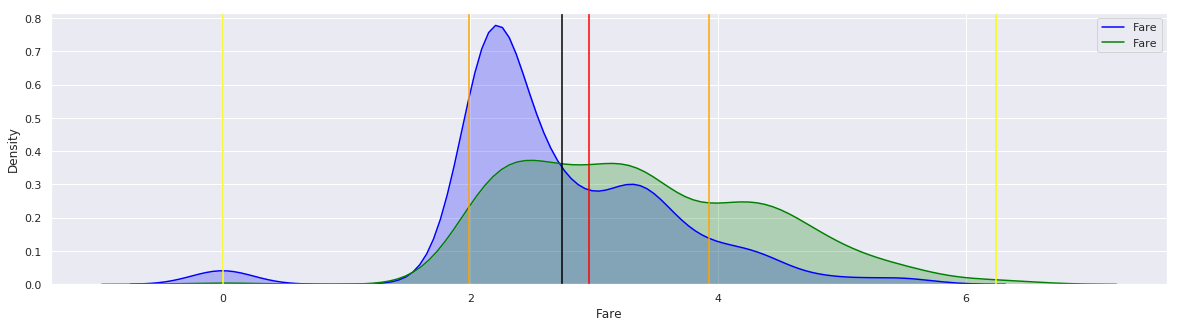

In [16]:
# perform a log transformation of the fare features in train and test! 
# Hint: You can use pandas apply method, for example: train.Fare = train.Fare.apply(lambda l: some method(l))
train.Fare = train.Fare.apply(lambda l: np.log(l+1))
test.Fare = test.Fare.apply(lambda l: np.log(l+1))
show_fare_distribution()

Ok, after transformation you are not yet finished with the fare: Normalize the feature to zero mean and unit variance using your own method or the StandardScaler of scikit-learn as you have done with the ages. 

In [17]:
train.Fare = scaler.fit_transform(train.Fare.values.reshape(-1,1))
test.Fare = scaler.transform(test.Fare.values.reshape(-1,1))

To pass this station, uncomment and run. If you are right, nothing shows up! ;-)

In [18]:
assert(np.round(np.mean(train.Fare), 2) == 0.)
assert(np.round(np.median(train.Fare), 2) == -0.23)
assert(np.round(np.min(train.Fare), 2) == -3.06)
assert(np.round(np.max(train.Fare), 2) == 3.39)
assert(np.round(np.std(train.Fare), 2) == 1.)
assert(np.round(np.mean(test.Fare), 2) == 0.05)
assert(np.round(np.median(test.Fare), 2) == -0.23)
assert(np.round(np.min(test.Fare), 2) == -3.06)
assert(np.round(np.max(test.Fare), 2) == 3.39)
assert(np.round(np.std(test.Fare), 2) == 1.)

## Station 5 - Categorical features

Let's dive into the next problem... Currently we set our categorical features either to 1 or 0. But is this really a good choice? Let's try to figure it out given the sex feature. There was a high chance to survive if the passenger was a female:

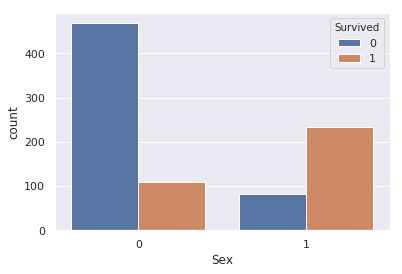

In [20]:
sns.countplot(x=train.Sex, hue=train.Survived);

If we would predict a probability of 0.5 for a male and for a female to survive, we would expect gradient contributions that point into opposite directions. But actually we obtain:

For females: $ (y - t) \cdot x_{sex} = (0.5 - 1) \cdot 1  = -0.5 $

For males: $ (y - t) \cdot x_{sex} = (0.5 - 1) \cdot 0 = 0 $

Zero contribution in this case is bad. Only if the prediction is equal to the target we would like to have a zero contribution. Consequently we could make progress if we would use values like 1 and -1 to describe the gender:

For females: $ (y - t) \cdot x_{sex} = (0.5 - 1) \cdot 1  = -0.5 $

For males: $ (y - t) \cdot x_{sex} = (0.5 - 1) \cdot -1 = 0.5 $

Now, both are pushed into different directions. This is great, especially in the case where the feature is powerful like the sex feature. This way we only need one parameter update step for the sex feature to separate our target groups. Let's use our new strategy:

In [21]:
train.Sex = train.Sex.apply(lambda l: np.where(l==0, -1, 1))
test.Sex = test.Sex.apply(lambda l: np.where(l==0, -1, 1))

In [22]:
# Perform this mapping for all remaining categorical features in train and test!

cols_to_use = [col for col in train.columns if col not in ["PassengerId", "Survived", "Age", "Sex", "Fare"]]
for col in cols_to_use:
    train[col] = train[col].apply(lambda l: np.where(l==0, -1, 1))

## Station 6- Speed up and pass the gate

Ok, let's show that we yield a better and faster convergence of the loss function by feature scaling and transformation! 

In [23]:
features = train.drop(["PassengerId", "Survived"], axis=1).columns

X = train[features].values
Y = train.Survived.values

X_old = original_train[features].values
Y_old = original_train.Survived.values

x_train, x_val, t_train, t_val = train_test_split(X, Y, random_state=0)
x_train_old, x_val_old, t_train_old, t_val_old = train_test_split(X_old, Y_old, random_state=0)

In [24]:
new_model = MyClassifier(x_train.shape[1])
new_model.learn(x_train, t_train)
new_losses = new_model.losses
new_score = new_model.score(x_val, t_val)
print(new_score)

0.8116591928251121


In [25]:
old_model = MyClassifier(x_train_old.shape[1])
old_model.learn(x_train_old, t_train_old)
old_losses = old_model.losses
old_score = old_model.score(x_val_old, t_val_old)
print(old_score)

0.7982062780269058


Text(0, 0.5, 'Loss')

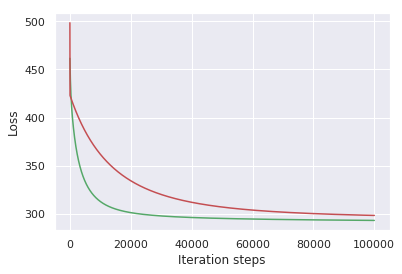

In [26]:
plt.figure()
plt.plot(new_losses, 'g')
plt.plot(old_losses, 'r')
plt.xlabel("Iteration steps")
plt.ylabel("Loss")

Obviously our loss decreases faster! Consequently we may reduce the iteration steps and/or increase the learning rate. :-)

In [ ]:
assert(np.round(old_score, 4) == 0.7982)
assert(np.round(new_score, 4) == 0.8117)